# **Cancer Image Analysis Competition**

### Shravan Venkatraman - 21BCE1200

#### **Link to the repository: https://github.com/shravan-18/Histopathological-Image-Analysis-Competition**

## **Continuation - Step 4 - Utilize Graph Convolutional Networks (GCNs) to Analyze Nucleus Features**
----------------------------------------------------------------------------------------

# Method 1:
- ### **Segmentation Using Otsu's Thresholding**

    - #### Segment foreground objects, specifically nuclei, from the background in grayscale images.
    
- ### **Feature Extraction**

    - #### Extract features such as area, perimeter, and eccentricity for each nucleus.
    - #### These features capture structural and textural aspects of the nuclei
    
- ### **Construction of Adjacency Graph**

    - #### Constructing a graph where nodes represent nuclei.
    - #### Each node in the graph corresponds to a nucleus identified in the image.
    - #### Edges Connecting Nearby Nuclei: Defining "nearby" based on a distance threshold.

## Import Dependencies and Prepare Data

In [1]:
!pip install -q --no-cache-dir torch-geometric

In [2]:
import cv2
import numpy as np
import pandas as pd
import os
import random
import matplotlib.pyplot as plt
     
from scipy.spatial.distance import cdist
from skimage.measure import regionprops_table, label
from skimage.color import rgb2gray
from skimage.measure import regionprops
from skimage import exposure


import torch
from torch import nn
from torch_geometric.nn import GCNConv, global_mean_pool
from torch.utils.data import DataLoader, Dataset
from torch_geometric.data import Data, Batch

import networkx as nx

In [3]:
# !mkdir '/kaggle/working/train-sampled'
# !mkdir '/kaggle/working/train-sampled/0'
# !mkdir '/kaggle/working/train-sampled/1'

In [ ]:
df = pd.read_csv('/kaggle/input/hcd-cropped/train_labels.csv')

# Directory paths
source_dir = '/kaggle/input/hcd-cropped/train'
target_dir = '/kaggle/working/train-sampled'

# Iterate through the filenames in the sampled_df DataFrame
for _, row in sampled_df.iterrows():
    filename = row['id']
    
    # Add the.tif extension
    full_filename = filename + '.tif'
    
    # Construct the full source and target paths
    src_path = os.path.join(source_dir, full_filename)
    tgt_path = os.path.join(target_dir, str(row['label']), full_filename)
    
    # Copy the file
    shutil.copy(src_path, tgt_path)

## Functions to Prepare Data for GNN and Unit Testing

In [14]:
def preprocess_and_segment(image_path):
    # Read the image
    image = cv2.imread(image_path)
    
    # Convert to grayscale
    gray_image = rgb2gray(image)
    
    # Convert the grayscale image to 8-bit unsigned integer format
    gray_image_8bit = (gray_image * 255).astype(np.uint8)
    
    # Apply Otsu's thresholding
    _, thresh_image = cv2.threshold(gray_image_8bit, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    # Label connected components
    labeled_image = label(thresh_image)
    
    return labeled_image


In [15]:
# Test Function to visualize the segmented output from OTSU Segmentation

def visualize_segmentation(original_image, labeled_image):
    # Convert the labeled image to RGB for visualization
    segmented_image = np.stack((labeled_image,) * 3, axis=-1)
    
    # Display the original and segmented images side by side
    fig, axes = plt.subplots(1, 2, figsize=(4, 4))
    axes[0].imshow(original_image)
    axes[0].set_title('Original Image')
    axes[1].imshow(segmented_image)
    axes[1].set_title('Segmented Image')
    plt.axis('off')
    plt.show()

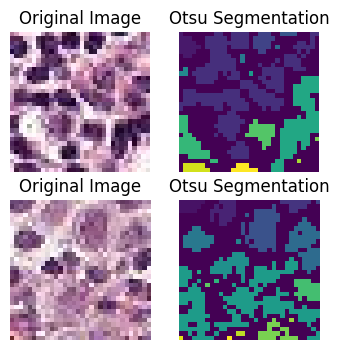

In [29]:
# Set directory path
dirr = '/kaggle/working/train-sampled/1'

# Select two random images from the directory
image_files = os.listdir(dirr)
image_path1 = os.path.join(dirr, image_files[random.randint(0, len(image_files) - 1)])
image_path2 = os.path.join(dirr, image_files[random.randint(0, len(image_files) - 1)])

# Read the original images
original_image1 = cv2.imread(image_path1)
original_image2 = cv2.imread(image_path2)

# Process the images to get the labeled images
labeled_image1 = preprocess_and_segment(image_path1)
labeled_image2 = preprocess_and_segment(image_path2)

# Convert the original images from BGR to RGB
original_image1_rgb = cv2.cvtColor(original_image1, cv2.COLOR_BGR2RGB)
original_image2_rgb = cv2.cvtColor(original_image2, cv2.COLOR_BGR2RGB)

# Plot the images side by side
plt.figure(figsize=(4, 4))

# Plot the first original image
plt.subplot(2, 2, 1)
plt.imshow(original_image1_rgb)
plt.title('Original Image')
plt.axis('off')

# Plot the first labeled image
plt.subplot(2, 2, 2)
plt.imshow(labeled_image1)
plt.title('Otsu Segmentation')
plt.axis('off')

# Plot the second original image
plt.subplot(2, 2, 3)
plt.imshow(original_image2_rgb)
plt.title('Original Image')
plt.axis('off')

# Plot the second labeled image
plt.subplot(2, 2, 4)
plt.imshow(labeled_image2)
plt.title('Otsu Segmentation')
plt.axis('off')

plt.show()

In [5]:
def extract_features(labeled_image):
    props = regionprops(labeled_image)
    features = []
    for prop in props:
        # Example features: area, perimeter, eccentricity
        feature_vector = [prop.area, prop.perimeter, prop.eccentricity]
        features.append(feature_vector)
    return np.array(features)

In [6]:
def construct_graph(features, coords, distance_threshold=30):
    # Create an empty graph
    G = nx.Graph()
    
    # Add nodes with features
    for i, feature in enumerate(features):
        G.add_node(i, feature=np.array(feature))
    
    # Compute pairwise distances between coordinates
    dist_matrix = cdist(coords, coords, 'euclidean')
    
    # Add edges based on distance threshold
    for i in range(len(coords)):
        for j in range(i+1, len(coords)):
            if dist_matrix[i, j] < distance_threshold:
                G.add_edge(i, j)
    
    return G


In [7]:
def graph_to_pyg_data(G):
    # Extract node features and edge indices
    node_features = np.array([data['feature'] for _, data in G.nodes(data=True)])
    edge_indices = np.array(list(G.edges())).T
    
    # Convert to tensors
    x = torch.tensor(node_features, dtype=torch.float)
    edge_index = torch.tensor(edge_indices, dtype=torch.long)
    
    # Create a Data object 
    labels = torch.tensor([0])  # Placeholder for temporary checks
    data = Data(x=x, edge_index=edge_index, y=labels)
    
    return data


In [8]:
# UNIT TEST

dirr = '/kaggle/working/train-sampled/0'
image_path = os.path.join(
    dirr, 
    os.listdir(dirr)[random.randint(0, len(os.listdir(dirr)))]
)
labeled_image = preprocess_and_segment(image_path)
features = extract_features(labeled_image)
coords = np.array([[int(prop.centroid[0]), int(prop.centroid[1])] for prop in regionprops(labeled_image)])
G = construct_graph(features, coords)
pyg_data = graph_to_pyg_data(G)
print(pyg_data)
print("Success")

Data(x=[5, 3], edge_index=[2, 10], y=[1])
Success


## Prepare Dataset and Dataloader

In [162]:
class HistopathologyGraphDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.image_paths = []
        for label in ['0', '1']:  # Assuming binary classification
            label_dir = os.path.join(root_dir, label)
            self.image_paths.extend([(label, os.path.join(label_dir, fname)) for fname in os.listdir(label_dir)])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        label, image_path = self.image_paths[idx]
        labeled_image = self.preprocess_and_segment(image_path)
        features = self.extract_features(labeled_image)
        coords = np.array([prop.centroid for prop in regionprops(labeled_image)])
        G = self.construct_graph(features, coords)
        
        if G is None or len(coords) == 0:
            return None  # Skip this sample
        
        pyg_data = self.graph_to_pyg_data(G, label=int(label))
        return pyg_data

    @staticmethod
    def preprocess_and_segment(image_path):
        image = cv2.imread(image_path)
        gray_image = rgb2gray(image)
        gray_image_8bit = (gray_image * 255).astype(np.uint8)
        _, thresh_image = cv2.threshold(gray_image_8bit, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        labeled_image = label(thresh_image)
        return labeled_image

    @staticmethod
    def extract_features(labeled_image):
        props = regionprops(labeled_image)
        features = [[prop.area, prop.perimeter, prop.eccentricity] for prop in props]
        return np.array(features)

    @staticmethod
    def construct_graph(features, coords, distance_threshold=20):
        if len(coords) == 0:
            return None
        
#         print("Objects detected in the image")
        G = nx.Graph()
        for i, feature in enumerate(features):
            G.add_node(i, feature=np.array(feature))

        if len(coords) > 1:  # Ensure there are at least two points to form an edge
            dist_matrix = cdist(coords, coords, 'euclidean')
            for i in range(len(coords)):
                for j in range(i+1, len(coords)):
                    if dist_matrix[i, j] < distance_threshold:
                        G.add_edge(i, j)
        return G

    @staticmethod
    def graph_to_pyg_data(G, label):
        node_features = np.array([data['feature'] for _, data in G.nodes(data=True)])
        edge_indices = np.array(list(G.edges())).T
        x = torch.tensor(node_features, dtype=torch.float)
        edge_index = torch.tensor(edge_indices, dtype=torch.long)
        y = torch.tensor([label], dtype=torch.long)
        data = Data(x=x, edge_index=edge_index, y=y)
        return data
    
    '''Visualization Functions'''
    def visualize_multiple(self, indices, figsize=(4, 4)):
        fig, axs = plt.subplots(2, 2, figsize=figsize)
        axs = axs.ravel()  # Flatten the array of Axes objects

        for ax, idx in zip(axs, indices):
#             print(f"Processing image {idx}")  
            label, image_path = self.image_paths[idx]
#             print(f"Image path: {image_path}")  
            labeled_image = self.preprocess_and_segment(image_path)
            features = self.extract_features(labeled_image)
            coords = np.array([prop.centroid for prop in regionprops(labeled_image)])
            G = self.construct_graph(features, coords)

            if G is None or len(coords) == 0:
                print(f"No graph available for Image {idx}")  
#                 ax.set_title(f"No graph available for Image {idx}")
                continue

#             print(f"Constructed graph with {len(G.nodes)} nodes and {len(G.edges)} edges") 

            # Read the original image
            original_image = cv2.imread(image_path)
            original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

            # Plot the original image
            ax.imshow(original_image_rgb)

            # Overlay the graph nodes and edges
            pos = {i: coord for i, coord in enumerate(coords)}
            nx.draw_networkx_nodes(G, pos, node_size=10, node_color='w', alpha=0.8, ax=ax)
            nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.5, edge_color='blue', ax=ax)

            ax.axis('off')
            ax.set_title(f"{'cancerous' if label else 'non-cancerous'}")

        plt.tight_layout()
        plt.show()


    
    def visualize(self, idx):
        label, image_path = self.image_paths[idx]
        labeled_image = self.preprocess_and_segment(image_path)
        features = self.extract_features(labeled_image)
        coords = np.array([prop.centroid for prop in regionprops(labeled_image)])
        G = self.construct_graph(features, coords)
        
        if G is None or len(coords) == 0:
            print("No graph available for this sample.")
            return
        
        # Read the original image
        original_image = cv2.imread(image_path)
        original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
        
        # Plot the original image
        plt.imshow(original_image_rgb)
        
        # Overlay the graph nodes and edges
        pos = {i: coord for i, coord in enumerate(coords)}
        nx.draw_networkx_nodes(G, pos, node_size=10, node_color='white', alpha=0.8, ax=ax)
        nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.5, edge_color='green', ax=ax)
        
        plt.axis('off')
        plt.title(f"{'cancerous' if label else 'non-cancerous'}")
        plt.show()


In [163]:
def collate_geometric(samples):
    # Filter out None values in case of skipped samples
    samples = list(filter(None, samples))
    if not samples:
        return None  # Return None if all samples were filtered out
    batch = Batch.from_data_list(samples)
    return batch

In [164]:
root_dir = '/kaggle/working/train-sampled'
dataset = HistopathologyGraphDataset(root_dir)
dataloader = DataLoader(dataset, batch_size=2048, shuffle=True, collate_fn=collate_geometric)

# # Example usage in a training loop
# for i, batch in enumerate(dataloader):
#     print(batch)
#     if i==10:
#         break


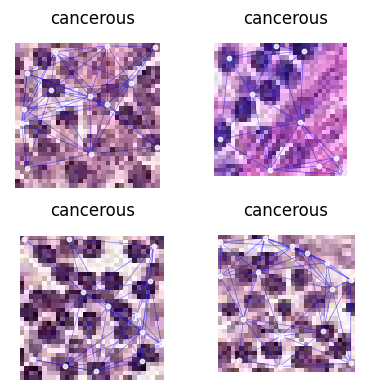

In [165]:
indices_to_visualize = [200, 1, 124, 275]
dataset.visualize_multiple(indices_to_visualize)

## Create Model

In [7]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, num_features=3, num_classes=2):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels*4)
        self.conv2 = GCNConv(hidden_channels*4, hidden_channels*2)
        self.conv3 = GCNConv(hidden_channels*2, hidden_channels)
        self.classifier = torch.nn.Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        x = self.conv3(x, edge_index).relu()
        x = global_mean_pool(x, batch)  # Pooling
        x = self.classifier(x)
        return nn.LogSoftmax(dim=1)(x)

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = GCN(hidden_channels=16).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

## Train Model (took a lot of time so ran only 8 epochs)

In [12]:
for epoch in range(8):
    print(f"Running Epoch: {epoch+1}")
    total_loss = 0
    
    for batch in dataloader:
        if batch is None:
#             print("None")
            continue  # Skip this iteration if the batch is None
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.batch)
        _, preds = torch.max(out, dim=1)  # Get the predicted class labels
        loss = criterion(out, batch.y)
#         print("Loss: ", loss)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(dataloader)
    print(f'Epoch {epoch+1}, Average Loss: {avg_loss}')


# Save the trained model
torch.save(model.state_dict(), 'gcn_model-otsu.pth')



Running Epoch: 1
Epoch 1, Average Loss: 0.9667343381378386
Running Epoch: 2
Epoch 2, Average Loss: 0.6642644068709126
Running Epoch: 3
Epoch 3, Average Loss: 0.6551524141320476
Running Epoch: 4
Epoch 4, Average Loss: 0.6650741795698801
Running Epoch: 5
Epoch 5, Average Loss: 0.6477518341055623
Running Epoch: 6
Epoch 6, Average Loss: 0.6366216582942892
Running Epoch: 7
Epoch 7, Average Loss: 0.6299260314084865
Running Epoch: 8
Epoch 8, Average Loss: 0.610172367228402
    


# Method 2:
- ### **Segmentation Using Simple Linear Iterative Clustering (SLIC)**

    - #### Images are segmented into superpixels, or segments, based on color similarity.
    - #### Number of segments, compactness, and sigma -  determine the granularity of the segmentation. 
    
- ### **Feature Extraction**

    - #### Mean color of each segment is calculated, serving as a feature vector for that segment (not the ideal choice for this use case, hence did not use this as primary method)
    
- ### **Construction of Adjacency Graph**

    - #### Graph is derived from the shape of the segmented image.

In [ ]:
import cv2
import numpy as np
from sklearn.feature_extraction.image import grid_to_graph
from skimage.segmentation import slic
from skimage.util import img_as_float
from scipy.sparse import coo_matrix
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
import torch
import os
import torch
from torch import nn
from torch_geometric.nn import GCNConv, global_mean_pool

# Prepare Data for GNN

In [1]:
def image_to_graph(image_path):
    # Load and normalize the image
    image = cv2.imread(image_path)
    image = img_as_float(image)
    
    # Segment the image using SLIC
    segments = slic(image, n_segments=250, compactness=10, sigma=3)
    
    # Create a graph from the segmented image
    graph = grid_to_graph(*segments.shape)
    
    # Extract features for each segment (mean color here)
    features = []
    for segment_id in np.unique(segments):
        mask = segments == segment_id
        features.append(np.mean(image[mask], axis=0))
    features = np.array(features)
    
    # Adjust edge_index to ensure indices are within bounds
    max_node_idx = features.shape[0] - 1
    graph.row = np.clip(graph.row, 0, max_node_idx)
    graph.col = np.clip(graph.col, 0, max_node_idx)
    
    return graph, features


# Create Dataset and Dataloader

In [4]:
class HistopathologyDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.graphs = []
        self.labels = []

        # Assuming your directory structure is as described
        for label in ['0', '1']:
            label_dir = f'{root_dir}/{label}'
            for image_path in os.listdir(label_dir):
                graph, features = image_to_graph(os.path.join(label_dir, image_path))
                edge_index = torch.tensor(graph.nonzero(), dtype=torch.long)
                x = torch.tensor(features, dtype=torch.float)
                y = torch.tensor(int(label), dtype=torch.long)
                data = Data(x=x, edge_index=edge_index, y=y)
                self.graphs.append(data)
                self.labels.append(y)

    def __len__(self):
        return len(self.graphs)

    def __getitem__(self, idx):
        return self.graphs[idx]

# Initialize the dataset
dataset = HistopathologyDataset('/kaggle/working/train-sampled')
loader = DataLoader(dataset, batch_size=32, shuffle=True)


/tmp/ipykernel_33/1084868380.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:261.)
  edge_index = torch.tensor(graph.nonzero(), dtype=torch.long)


# Create Model

In [18]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, num_features=3, num_classes=2):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.classifier = torch.nn.Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        x = global_mean_pool(x, batch)  # Pooling
        x = self.classifier(x)
        return nn.LogSoftmax(dim=1)(x)

In [19]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = GCN(hidden_channels=16).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Train Model

In [20]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = GCN(hidden_channels=16).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(64):
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    
    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.batch)
        _, preds = torch.max(out, dim=1)  # Get the predicted class labels
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
        # Calculate accuracy
        correct_predictions += (preds == batch.y).sum().item()
        total_predictions += batch.y.size(0)
    
    avg_loss = total_loss / len(loader)
    accuracy = correct_predictions / total_predictions
    print(f'Epoch {epoch}, Average Loss: {avg_loss}')


# Save the trained model
torch.save(model.state_dict(), 'gcn_model-slic.pth')

Epoch 0, Average Loss: 0.5608673851163392, Accuracy: 0.7139825019884104
Epoch 1, Average Loss: 0.5305780589909939, Accuracy: 0.7409703442790592
Epoch 2, Average Loss: 0.5215260653196898, Accuracy: 0.7475423247358255
Epoch 3, Average Loss: 0.5156459790275775, Accuracy: 0.7520918077491194
Epoch 4, Average Loss: 0.5115301529570782, Accuracy: 0.7562867855925463
Epoch 5, Average Loss: 0.5071617600103323, Accuracy: 0.7582774684694921
Epoch 6, Average Loss: 0.5046418507763852, Accuracy: 0.7620179525053972
Epoch 7, Average Loss: 0.5022124010265532, Accuracy: 0.764031360072719
Epoch 8, Average Loss: 0.5010548200633825, Accuracy: 0.7636132257697988
Epoch 9, Average Loss: 0.49922376370719523, Accuracy: 0.7654766503806386
Epoch 10, Average Loss: 0.4972697682440316, Accuracy: 0.7665856152709919
Epoch 11, Average Loss: 0.4959307140570487, Accuracy: 0.7673037154868765
Epoch 12, Average Loss: 0.49575428621341766, Accuracy: 0.7673991591864561
Epoch 13, Average Loss: 0.4950246784149075, Accuracy: 0.7676

## **Other Models**

### Played around with GATs but they were overfitting so ditched...

In [ ]:
import torch
from torch import nn
from torch_geometric.nn import GATConv, GCNConv
from torch_geometric.nn import global_mean_pool
from sklearn.metrics import accuracy_score

class GCN(torch.nn.Module):
    def __init__(self, in_channels: int = 3, hidden_dim: int = 152, num_classes: int = 2):
        super(GCN, self).__init__()

        self.in_channels = in_channels
        
        self.conv1 = GATConv(in_channels=in_channels, out_channels=hidden_dim)
        self.conv2 = GATConv(in_channels=hidden_dim, out_channels=hidden_dim)
        self.conv3 = GATConv(in_channels=in_channels + hidden_dim, out_channels=hidden_dim)

        self.fc = nn.Sequential(
            nn.Linear(in_channels + 3 * hidden_dim, 256),
            nn.ReLU(True),
            nn.Linear(256, 32),
            nn.ReLU(True),
            nn.Linear(32, 32),
            nn.ReLU(True),
            nn.Linear(32, num_classes),
        )

    def forward_one_base(self, node_features: torch.Tensor, edge_indices: torch.Tensor) -> torch.Tensor:
        assert node_features.ndim == 2 and node_features.shape[1] == self.in_channels
        assert edge_indices.ndim == 2 and edge_indices.shape[0] == 2

        x0 = node_features

        x1 = self.conv1(x0, edge_indices)

        x2 = self.conv2(x1, edge_indices)
        x0_x2 = torch.cat((x0, x2), dim=-1)

        x3 = self.conv3(x0_x2, edge_indices)
        x0_x1_x2_x3 = torch.cat((x0, x1, x2, x3), dim=-1)

        return x0_x1_x2_x3

    def forward(self, batch_node_features: list[torch.Tensor], batch_edge_indices: list[torch.Tensor]) -> torch.Tensor:
        assert len(batch_node_features) == len(batch_edge_indices)

        features_list = []
        for node_features, edge_indices in zip(batch_node_features, batch_edge_indices):
            features_list.append(self.forward_one_base(node_features=node_features, edge_indices=edge_indices))

        features = torch.stack(features_list, dim=0)  # BATCH_SIZE x NUM_NODES x NUM_FEATURES
        features = features.mean(dim=1)  # readout operation [BATCH_SIZE x NUM_FEATURES]

        logits = self.fc(features)
        return logits
    